<a href="https://colab.research.google.com/github/M-Jahanzaib6062/PyTorch-Beginner-to-Advanced/blob/main/01_PyTorch_Workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **01_PyTorch_Workflow_Fundamentals**

In this notebook we will cover a standard PyTorch Workflow. We will discuss several steps from getting data to saving the trained model.

For the sake of simplicity, we will be considering a simple regression problem, a problem that can be solved using linear regression.

The steps of workflow are as follows:
* Getting data ready
* Building a model
* Fitting the model to data (training)
* Making predictions on new data and model evaluation (inference)
* Saving and loading the trained model

# **Import packages**

Before going through the workflow, we must import the required packages.

In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt

"nn" stands for neural network, it a package in PyTorch Library that includes the building blocks for creating neural networks.

While "matplolib" is for data visualization.

# Step 1: Data (Loading/Generating and Preprocessing)

For simplicity and ease of understanding we will be considering simple linear data which can be predicted by a linear regression model by mapping a straight line on the data.

Let's generate the data using the equation of straight line

              Y = (m * X) + c

Where "m" is the slope and "c" is the intercept.

## Generate Data

In [ ]:
m = 0.7
c = 0.3
X = torch.arange(0, 1, 0.02).unsqueeze(dim = 1)
print(X[:5])
print(X.shape)
Y = m * X + c
print(Y[:5])

tensor([[0.0000],
        [0.0200],
        [0.0400],
        [0.0600],
        [0.0800]])
torch.Size([50, 1])
tensor([[0.3000],
        [0.3140],
        [0.3280],
        [0.3420],
        [0.3560]])


## Split Data

Splitting the Data is very important in machine learning and deep learning.

The Data in split into three sets:
* Training Set
* Validation Set
* Testing Set

The model is trained using the training set.
The model in validated on the validation set during training for hyper-parameter tunning.
And finally the test set is used to calculate the generalization performance.

It is preferred to use Validation set but it is not a must. Everything can work just with training and test sets.

In [ ]:
training_percent = 0.8 # 80% data for training, remaining for testing.
train_index = int(training_percent * len(X))
train_x = X[:train_index]
train_y = Y[:train_index]
test_x = X[train_index:]
test_y = Y[train_index:]

print(f'train_x shape is {train_x.shape}')
print(f'test_x shape is {test_y.shape}')

train_x shape is torch.Size([40, 1])
test_x shape is torch.Size([10, 1])


* 40 instances will be used for training.
* 10 instances will be used ofr testing model performance.

## Data Visualization

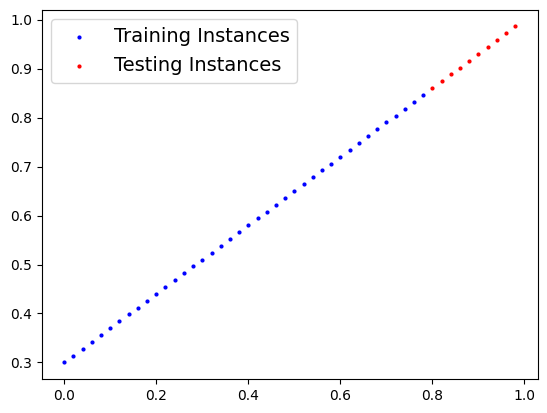

In [ ]:
def PlotData(train_x, train_y, test_x, test_y, predictions = None):
  plt.scatter(train_x, train_y, c = "b", s = 4, label = "Training Instances")
  plt.scatter(test_x, test_y, c = "r", s = 4, label = "Testing Instances")
  if predictions is not None:
    plt.scatter(test_x, predictions, c = "g", s = 4, label = "Predictions")
  plt.legend(prop = {'size':14})
  plt.show()

PlotData(train_x, train_y, test_x, test_y)

# **Step 2: Build Model**

Now we've got some data, let's build a model to use the blue dots to predict the red dots.

## Model Class

We will be using the term "weight" for slope and "bias" for the intercept.

**Note:** We already know the values of actual weight and bias, which we used while generating the data. We are trying to build a linear regression model to see whether it can estimate those parameter values or not.

In [ ]:
class LinearModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.weight = nn.Parameter(torch.randn(1,
                                dtype = torch.float),
                                requires_grad = True)
    self.bias = nn.Parameter(torch.randn(1,
                             dtype = torch.float),
                             requires_grad = True)
  def forward(self, x : torch.Tensor) -> torch.Tensor:
    return self.weight * x + self.bias

## Checking contents of model

First we will create an object of the model class (LinearModel), then use ".parameters()" function to see what parameters it contains.

We can also use the "state_dict()" method.

In [ ]:
torch.manual_seed(42)

model = LinearModel()

print(list(model.parameters()))

[Parameter containing:
tensor([0.3367], requires_grad=True), Parameter containing:
tensor([0.1288], requires_grad=True)]


So this shows the model has two parameters, weight = 0.7 and bias = 0.3.

Both are randomly intialized.

In [ ]:
model.state_dict()

OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])

## Making Predictions

In [ ]:
with torch.inference_mode():
  pred = model(test_x)

**Note:** In older PyTorch code, you may also see "torch.no_grad()" being used for inference. While "torch.inference_mode()" and "torch.no_grad()" do similar things, "torch.inference_mode()" is newer, potentially faster and preferred.

In [ ]:
print(f'Predicted value: \n{pred}')

Predicted value: 
tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])


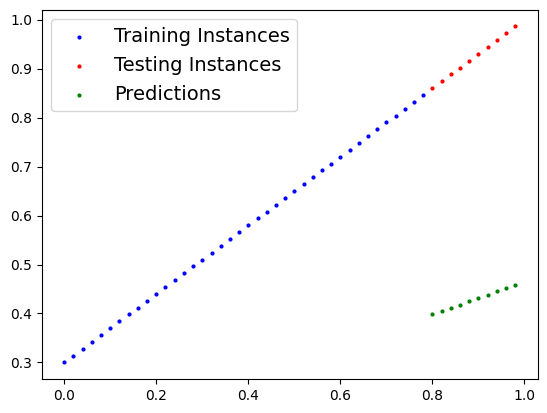

In [ ]:
PlotData(train_x, train_y, test_x, test_y, pred)

The predictions look pretty far away.

This is because we haven't trained the model.

# **Step 3: Train Model**

In training, the optimization algorithm tries to find parameters values that make model predictions closer to the actual values.

## Loss function and Optimizer

**Loss function**: It measures how close the predicted values are from the actual values (labels).

The closer the values are the better.

**Optimizer**: It tries to update model parameters so as it decrease the loss.

Depending on what kind of problem you're working on will depend on what loss function and what optimizer you use.

For our problem, since we are predicting a single continuous number, we will be using the MAE (Mean Absolute Error) Loss function and SGD (Stochastic Gradient Descent) optimizer.


In PyTorch, MAE is implemented as "L1Loss()" and can be accessses as "torch.nn.L1Loss()".

The Optimizer in present in the "torch.optim" module, "torch.optim.SGD()".

In [ ]:
loss_func = torch.nn.L1Loss()
optimizer = torch.optim.SGD(params = model.parameters(), lr = 0.01)

## Training Loop

In [ ]:
torch.manual_seed(42)
epochs = 150
train_losses = []
test_losses = []
epoch_count = []

for epoch in range(epochs):

  model.train() # Set model in Training model
  train_pred = model(train_x)
  train_loss = loss_func(train_pred, train_y)
  optimizer.zero_grad()
  train_loss.backward()
  optimizer.step()

  model.eval() # Set model in Evaluation mode
  with torch.inference_mode():
    test_pred = model(test_x)
    test_loss = loss_func(test_pred, test_y)
    if epoch % 10 == 0:
      epoch_count.append(epoch)
      train_losses.append(train_loss.detach().numpy())
      test_losses.append(test_loss.detach().numpy())
      print(f'Epoch: {epoch}\tTraining Loss: {train_loss}\tTesting Loss: {test_loss}')

Epoch: 0	Training Loss: 0.31288138031959534	Testing Loss: 0.48106518387794495
Epoch: 10	Training Loss: 0.1976713240146637	Testing Loss: 0.3463551998138428
Epoch: 20	Training Loss: 0.08908725529909134	Testing Loss: 0.21729660034179688
Epoch: 30	Training Loss: 0.053148526698350906	Testing Loss: 0.14464017748832703
Epoch: 40	Training Loss: 0.04543796554207802	Testing Loss: 0.11360953003168106
Epoch: 50	Training Loss: 0.04167863354086876	Testing Loss: 0.09919948130846024
Epoch: 60	Training Loss: 0.03818932920694351	Testing Loss: 0.08886633068323135
Epoch: 70	Training Loss: 0.03476089984178543	Testing Loss: 0.0805937647819519
Epoch: 80	Training Loss: 0.03132382780313492	Testing Loss: 0.07232122868299484
Epoch: 90	Training Loss: 0.02788739837706089	Testing Loss: 0.06473556160926819
Epoch: 100	Training Loss: 0.024458957836031914	Testing Loss: 0.05646304413676262
Epoch: 110	Training Loss: 0.021020207554101944	Testing Loss: 0.04819049686193466
Epoch: 120	Training Loss: 0.01758546568453312	Testi

/tmp/ipython-input-112-901586675.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


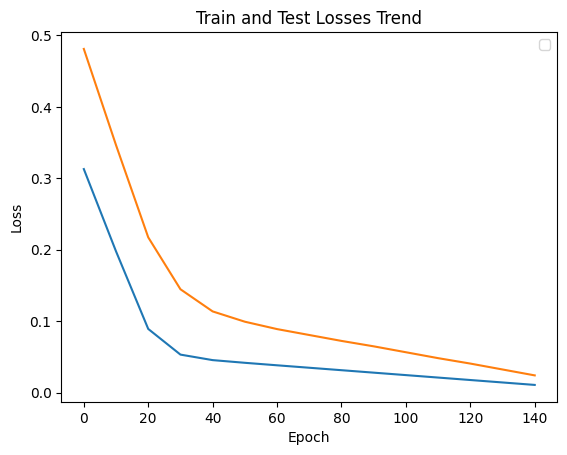

In [ ]:
plt.plot(epoch_count, train_losses)
plt.plot(epoch_count, test_losses)
plt.title("Train and Test Losses Trend")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()


Let's see how close the model parameter values are to the actual values after training.

In [ ]:
model.state_dict()

OrderedDict([('weight', tensor([0.6638])), ('bias', tensor([0.3153]))])

They are quite close to the actual values, weight = 0.7 and bias = 0.3.

# **Step 4: Inference**

In [ ]:
model.eval()
with torch.inference_mode():
  y_pred = model(test_x)
print(y_pred)

tensor([[0.8464],
        [0.8596],
        [0.8729],
        [0.8862],
        [0.8995],
        [0.9127],
        [0.9260],
        [0.9393],
        [0.9526],
        [0.9659]])


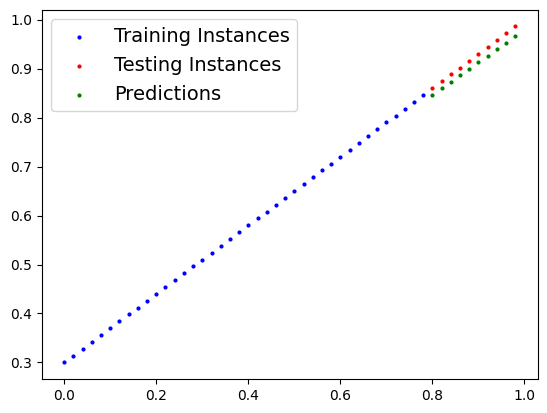

In [ ]:
PlotData(train_x, train_y, test_x, test_y, y_pred)

# **Step 5: Saving and Loading a PyTorch model**

For saving and loading models in PyTorch, there are three main methods we should be aware of, they are:
* torch.save()
* torch.load()
* torch.nn.Module.load_state_dict()

## Saving a PyTorch Model's state_dict()

We will be using the "pathlib" module of python to create a folder to contain all our models.

In [ ]:
from pathlib import Path

model_path = Path("Models")
model_path.mkdir(parents = True, exist_ok = True)

model_file_name = "01_pytorch_workflow_model_0.pth"
destination_path = model_path / model_file_name

torch.save(obj = model.state_dict(), f = destination_path)

## Loading a saved PyTorch model's state_dict()

In [ ]:
model1 = LinearModel()
model1.load_state_dict(torch.load('/content/Models/01_pytorch_workflow_model_0.pth'))

<All keys matched successfully>

In [ ]:
model1.state_dict()

OrderedDict([('weight', tensor([0.6638])), ('bias', tensor([0.3153]))])

In [ ]:
model1.eval()
with torch.inference_mode():
  loaded_model_pred = model1(test_x)
print(loaded_model_pred)


tensor([[0.8464],
        [0.8596],
        [0.8729],
        [0.8862],
        [0.8995],
        [0.9127],
        [0.9260],
        [0.9393],
        [0.9526],
        [0.9659]])


In [ ]:
y_pred == loaded_model_pred

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

It looks like the loaded model predictions are the same as the previous model predictions (predictions made prior to saving). This indicates our model is saving and loading as expected.